In [1]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(1000, 64)

In [2]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras import preprocessing

max_features = 10000
maxlen = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding

model = Sequential()
model.add(Embedding(10000, 8, input_length=maxlen))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 8)             80000     
_________________________________________________________________
flatten (Flatten)            (None, 160)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 161       
Total params: 80,161
Trainable params: 80,161
Non-trainable params: 0
_________________________________________________________________


In [4]:
history = model.fit(x_train, y_train, epochs=10, 
                    batch_size=32, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 1s 801us/step - loss: 0.6742 - acc: 0.6097 - val_loss: 0.6308 - val_acc: 0.6924
Epoch 2/10
625/625 [==============================] - 0s 665us/step - loss: 0.5502 - acc: 0.7508 - val_loss: 0.5315 - val_acc: 0.7274
Epoch 3/10
625/625 [==============================] - 0s 660us/step - loss: 0.4644 - acc: 0.7883 - val_loss: 0.5041 - val_acc: 0.7460
Epoch 4/10
625/625 [==============================] - 0s 671us/step - loss: 0.4225 - acc: 0.8097 - val_loss: 0.4957 - val_acc: 0.7548
Epoch 5/10
625/625 [==============================] - 0s 651us/step - loss: 0.3943 - acc: 0.8238 - val_loss: 0.4926 - val_acc: 0.7566
Epoch 6/10
625/625 [==============================] - 0s 651us/step - loss: 0.3715 - acc: 0.8357 - val_loss: 0.4951 - val_acc: 0.7578
Epoch 7/10
625/625 [==============================] - 0s 652us/step - loss: 0.3505 - acc: 0.8492 - val_loss: 0.4976 - val_acc: 0.7554
Epoch 8/10
625/625 [==============================] - 0s 652us

In [5]:
import os

imdb_dir = '../datasets/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [6]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)

In [7]:
len(word_index)

88582

In [8]:
data.shape

(25000, 100)

In [9]:
labels.shape

(25000,)

In [10]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [11]:
glove_dir = '../datasets/glove.6B'

embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
len(embeddings_index)

400000

In [12]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [13]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [15]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=32, 
                    validation_data=(x_val, y_val))
model.save_weights('pre_trained_glove_model.h5')

Epoch 1/10
7/7 [==============================] - 1s 68ms/step - loss: 1.4506 - acc: 0.5150 - val_loss: 0.7113 - val_acc: 0.5033
Epoch 2/10
7/7 [==============================] - 0s 58ms/step - loss: 0.5928 - acc: 0.6900 - val_loss: 1.8002 - val_acc: 0.5026
Epoch 3/10
7/7 [==============================] - 0s 63ms/step - loss: 0.6679 - acc: 0.6850 - val_loss: 1.0355 - val_acc: 0.5026
Epoch 4/10
7/7 [==============================] - 0s 58ms/step - loss: 0.5362 - acc: 0.7450 - val_loss: 0.8819 - val_acc: 0.5029
Epoch 5/10
7/7 [==============================] - 0s 58ms/step - loss: 0.2914 - acc: 0.9050 - val_loss: 1.6857 - val_acc: 0.4979
Epoch 6/10
7/7 [==============================] - 0s 55ms/step - loss: 0.4207 - acc: 0.8200 - val_loss: 0.7329 - val_acc: 0.5605
Epoch 7/10
7/7 [==============================] - 0s 60ms/step - loss: 0.1433 - acc: 0.9850 - val_loss: 0.7085 - val_acc: 0.5759
Epoch 8/10
7/7 [==============================] - 0s 57ms/step - loss: 0.0787 - acc: 1.0000 - val

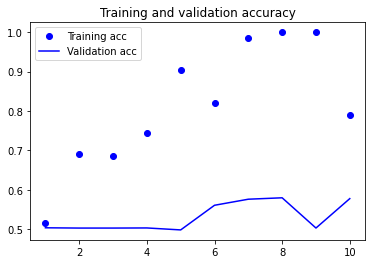

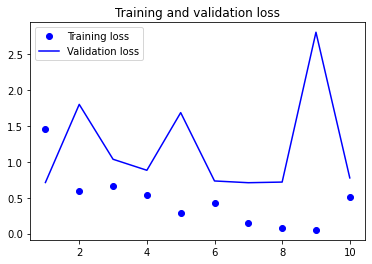

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=32, 
                    validation_data=(x_val, y_val))

Epoch 1/10
7/7 [==============================] - 1s 71ms/step - loss: 0.6938 - acc: 0.5050 - val_loss: 0.6920 - val_acc: 0.5135
Epoch 2/10
7/7 [==============================] - 0s 57ms/step - loss: 0.5106 - acc: 0.9950 - val_loss: 0.6949 - val_acc: 0.5165
Epoch 3/10
7/7 [==============================] - 0s 61ms/step - loss: 0.3149 - acc: 0.9950 - val_loss: 0.7069 - val_acc: 0.5153
Epoch 4/10
7/7 [==============================] - 0s 59ms/step - loss: 0.1602 - acc: 1.0000 - val_loss: 0.7235 - val_acc: 0.5149
Epoch 5/10
7/7 [==============================] - 0s 59ms/step - loss: 0.0816 - acc: 1.0000 - val_loss: 0.7030 - val_acc: 0.5310
Epoch 6/10
7/7 [==============================] - 0s 60ms/step - loss: 0.0420 - acc: 1.0000 - val_loss: 0.7133 - val_acc: 0.5230
Epoch 7/10
7/7 [==============================] - 0s 59ms/step - loss: 0.0223 - acc: 1.0000 - val_loss: 0.7246 - val_acc: 0.5223
Epoch 8/10
7/7 [==============================] - 0s 58ms/step - loss: 0.0128 - acc: 1.0000 - val

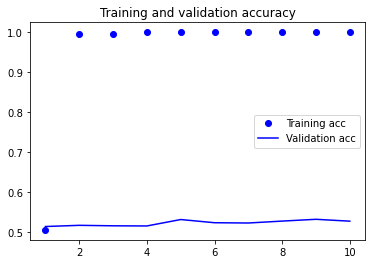

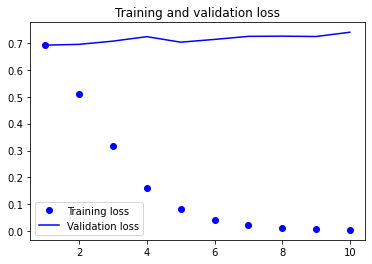

In [19]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
training_samples = 2000
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

In [21]:
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, 
                    epochs=10, batch_size=32, 
                    validation_data=(x_val, y_val))

Epoch 1/10
63/63 [==============================] - 1s 13ms/step - loss: 0.6842 - acc: 0.5570 - val_loss: 0.6617 - val_acc: 0.6354
Epoch 2/10
63/63 [==============================] - 1s 11ms/step - loss: 0.3247 - acc: 0.9530 - val_loss: 0.5749 - val_acc: 0.6961
Epoch 3/10
63/63 [==============================] - 1s 12ms/step - loss: 0.0422 - acc: 0.9995 - val_loss: 0.5503 - val_acc: 0.7286
Epoch 4/10
63/63 [==============================] - 1s 11ms/step - loss: 0.0035 - acc: 1.0000 - val_loss: 0.6044 - val_acc: 0.7323
Epoch 5/10
63/63 [==============================] - 1s 11ms/step - loss: 2.9325e-04 - acc: 1.0000 - val_loss: 0.6840 - val_acc: 0.7251
Epoch 6/10
63/63 [==============================] - 1s 11ms/step - loss: 2.4498e-05 - acc: 1.0000 - val_loss: 0.6996 - val_acc: 0.7479
Epoch 7/10
63/63 [==============================] - 1s 12ms/step - loss: 2.7216e-06 - acc: 1.0000 - val_loss: 0.7526 - val_acc: 0.7495
Epoch 8/10
63/63 [==============================] - 1s 11ms/step - loss

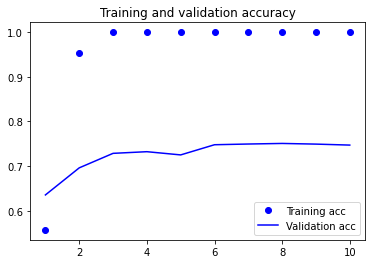

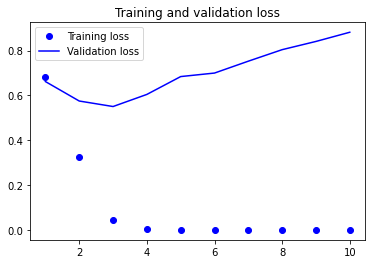

In [22]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
test_dir = os.path.join(imdb_dir, 'test')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname), encoding='utf8')
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [24]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

In [25]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)

782/782 [==============================] - 1s 1ms/step - loss: 0.7573 - acc: 0.5899


[0.7572990655899048, 0.5898799896240234]